In [2]:
# coding=utf-8

import numpy as np
import matplotlib.pyplot as plt
import sys, os, math, time
from scipy.signal import butter, lfilter
from scipy import signal

from pycbc import types,fft,waveform
from pycbc.waveform import get_td_waveform,get_fd_waveform,get_fd_waveform_sequence
from pycbc.conversions import q_from_mass1_mass2,mchirp_from_mass1_mass2,primary_mass,secondary_mass
from pycbc import types,fft,waveform
from pycbc.psd.read import from_numpy_arrays
from pycbc.conversions import mass1_from_mchirp_q,mass2_from_mchirp_q
from gensignal import gen_signal,gen_signal_fre,get_fd_htilde_lm,get_fd_LISATDI

from pyIMRPhenomD import IMRPhenomD, MSUN_SI, PC_SI
import Cosmology
import LISAConstants as LC
from LISAhdf5 import LISAhdf5,ParsUnits
from pyFDresponse import *
from psd import parse_arguments,Series
from tdi import *
from GenerateFD_SignalTDIs import *
from LISACommonFunctions import *
from pycbc.waveform.utils import phase_from_frequencyseries,amplitude_from_frequencyseries
import lal


(1e-05, 1.0)

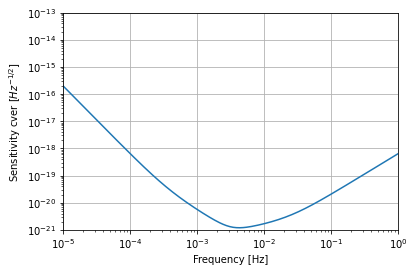

In [6]:
%matplotlib inline
#LISA sensitivity curve 
fre = logsampling(1e-5,1.0,200)
lisasen = lisasens(fre,includewd=None)
plt.loglog(fre,np.sqrt(fre*lisasen))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Sensitivity cver [$Hz^{-1/2}$]')
plt.grid()
plt.ylim(1e-21,1e-13)
plt.xlim(1e-5,1e0)

1000001


<function matplotlib.pyplot.show(*args, **kw)>

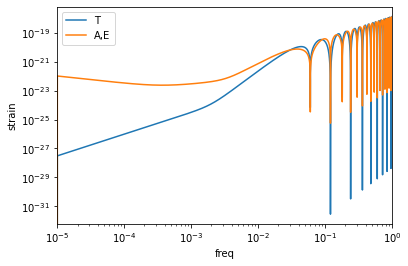

In [7]:
#analytic PSD of noise for TDI A, E and T
del_f= 1e-6
f= np.arange(1e-5,1.0,del_f)
flen = int(1.0/del_f)+1
flow=1e-5
print(flen)
#freq= logsampling(1e-5,1.0,200)
PSD_TDIT= noisepsd_T(f)
PSD_TDIAE= noisepsd_AE(f)
L= 2.5e9/LC.c
PSD_TDIae= PSD_TDIAE/(2*np.sin(2*np.pi*f*L)**2)
PSD_TDIt= PSD_TDIT/(8*np.sin(np.pi*f*L)**2*np.sin(2*np.pi*f*L)**2)
#We can define a strain-like noise PSD
PSD_TDIae= PSD_TDIae/(6*np.pi*f*L)**2
PSD_TDIt= PSD_TDIt/(6*np.pi*f*L)**2

PSD_TDIt = from_numpy_arrays(f, PSD_TDIt, flen, del_f,flow)
PSD_TDIae = from_numpy_arrays(f, PSD_TDIae, flen, del_f,flow)
PSD_TDIT = from_numpy_arrays(f, PSD_TDIT, flen, del_f,flow)
PSD_TDIAE = from_numpy_arrays(f, PSD_TDIAE, flen, del_f,flow)
plt.loglog(PSD_TDIT.sample_frequencies,np.sqrt(PSD_TDIT*PSD_TDIT.sample_frequencies),label='T')
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show

pycbc: generate FD waveform

In [8]:
#assume a signal
z=1
m1s=2e5
m2s=2e4

#dimensionless spins: a=cos(theta_s)*s
chi1 = 0.0
chi2 = 0.0


#t0= np.random.uniform(0.0,5.0)
t0=0.05
#Ecliptic Longitude, Latitude
theta=1.0
phi=1.5
lambd =  phi 
beta = np.pi/2 -theta

inc = 0.5
DL = Cosmology.DL(z, w=0)[0] # in Mpc
print(DL)

#phi0 = np.random.uniform(0.0, 2.0*np.pi)
#psi = np.random.uniform(0.0, 2.0*np.pi)   #pols=psi

psi=0.8
phi0=0.0

print('t0,phi0,psi',t0,phi0,psi)
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[fRef, trajdict, TDItag] = [0., trajdict_MLDC, "TDIXYZ"]


#Masses quoted in the hdf5 files are always redshifted masses.
#m1 =  m1s*(1+z)  ### redshifted masses
#m2 =  m2s*(1+z)
m1=m1s
m2=m2s
print(m1,m2)
chirp_mass=mchirp_from_mass1_mass2(m1,m2)
q=q_from_mass1_mass2(m1,m2)
print(mass1_from_mchirp_q(chirp_mass,q),mass2_from_mchirp_q(chirp_mass,q))

6823.090480179816
t0,phi0,psi 0.05 0.0 0.8
200000.0 20000.0
200000.00000000006 20000.000000000007


200000.00000000006 200000.00000000006
chirp mass 49289.164742357876
mass ratio 10.0
220000.00000000006
m10,m20 20.000000000000007 2.000000000000001
flow 2.272727272727272
rescale 10000.0
Fs 0.002


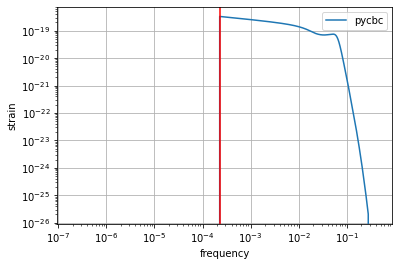

2e-07


In [9]:

m10=m1=mass1_from_mchirp_q(chirp_mass,q)
m20=m2=mass2_from_mchirp_q(chirp_mass,q)

print(m10,m1)
print('chirp mass',chirp_mass)
print('mass ratio',q)

M1=m1+ m2 
print(M1)
#m1 >m2


while(m10>100):
    m10=m10/10
if(m10>50):
    m10=m10/4
m20=m10/q
print('m10,m20',m10,m20)

M0=m10+m20
flower=50/M0
print('flow',flower)
apx = ['SEOBNRv4HM','IMRPhenomXHM','IMRPhenomD']
rescale=M1/M0
print('rescale',rescale)


modes=[[[2,2]],[[2,2],[2,1],[3,2],[3,3],[4,4]],[[2,2],[2,1],[3,2],[3,3],[4,4]]] 
Fs=(2e-07)*rescale
print('Fs',Fs)



hpf, hcf = get_fd_waveform(approximant=apx[1],
                         mass1=m10,
                         mass2=m20,
                         spin1z=chi1,
                         spin2z=chi2,
                         distance=DL,
                         inclination=inc,
                         coa_phase=phi0,
                         delta_f=Fs,
                         f_lower=flower,
                         mode_array=modes[0])

#rescale the time/frequency and amplitude
hpf22=types.FrequencySeries(hpf.data.data[:],delta_f=hpf.delta_f/rescale)*rescale**2
hcf22=types.FrequencySeries(hcf.data.data[:],delta_f=hcf.delta_f/rescale)*rescale**2

%matplotlib inline
plt.loglog(hpf22.sample_frequencies,abs(hpf22)*hpf22.sample_frequencies,label='pycbc')
plt.axvline(x=flower/rescale,color='red')
plt.xlabel('frequency')
plt.ylabel('strain')
#plt.xlim(1e-5,1)
plt.legend()
plt.grid()
plt.show()
print(hpf22.delta_f)




In [6]:

# f =np.logspace(-1,3,1000)
# hp, hc = get_fd_waveform_sequence(approximant=apx[1],
#                          mass1=m10,
#                          mass2=m20,
#                          spin1z=chi1,
#                          spin2z=chi2,
#                          distance=DL,
#                          inclination=inc,
#                          coa_phase=phi0,
#                          sample_points=f,
#                          mode_array=modes[0])

0.5 0.0
(0.5559275092616359+0j)


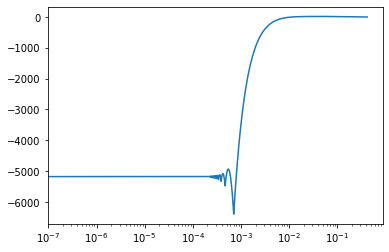

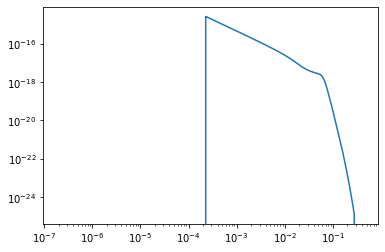

In [10]:
l,m= 2,2
print(inc,phi0)
Y22= lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,m)
print(Y22)
htilde22 = (hpf22.real() -1j*hcf22.real())/Y22

phase = phase_from_frequencyseries(htilde22,remove_start_phase=False)
amp = amplitude_from_frequencyseries(htilde22)

plt.semilogx(phase.sample_frequencies,-phase+phase[-1])
plt.show()

plt.loglog(amp.sample_frequencies,abs(amp))
plt.show()

generate waveform mode-by-mode

In [11]:
hpf_HM21, hcf_HM21= get_fd_waveform(approximant=apx[1],
                         mass1=m10,
                         mass2=m20,
                         spin1z=chi1,
                         spin2z=chi2,
                         distance=DL,
                         inclination=inc,
                         coa_phase=phi0,
                         delta_f=Fs,
                         f_lower=flower,
                         mode_array=[[2,1]])   
                         
hpf_HM32, hcf_HM32= get_fd_waveform(approximant=apx[1],
                         mass1=m10,
                         mass2=m20,
                         spin1z=chi1,
                         spin2z=chi2,
                         distance=DL,
                         inclination=inc,
                         coa_phase=phi0,
                         delta_f=Fs,
                         f_lower=flower,
                         mode_array=[[3,2]])   

hpf_HM33, hcf_HM33= get_fd_waveform(approximant=apx[1],
                         mass1=m10,
                         mass2=m20,
                         spin1z=chi1,
                         spin2z=chi2,
                         distance=DL,
                         inclination=inc,
                         coa_phase=phi0,
                         delta_f=Fs,
                         f_lower=flower,
                         mode_array=[[3,3]])   
hpf_HM44, hcf_HM44= get_fd_waveform(approximant=apx[1],
                         mass1=m10,
                         mass2=m20,
                         spin1z=chi1,
                         spin2z=chi2,
                         distance=DL,
                         inclination=inc,
                         coa_phase=phi0,
                         delta_f=Fs,
                         f_lower=flower,
                         mode_array=[[4,4]])   

hpf_HM21_rescale=types.FrequencySeries(hpf_HM21.data.data[:],delta_f=hpf_HM21.delta_f/rescale)*rescale**2
hpf_HM32_rescale=types.FrequencySeries(hpf_HM32.data.data[:],delta_f=hpf_HM32.delta_f/rescale)*rescale**2
hpf_HM33_rescale=types.FrequencySeries(hpf_HM33.data.data[:],delta_f=hpf_HM33.delta_f/rescale)*rescale**2
hpf_HM44_rescale=types.FrequencySeries(hpf_HM44.data.data[:],delta_f=hpf_HM44.delta_f/rescale)*rescale**2

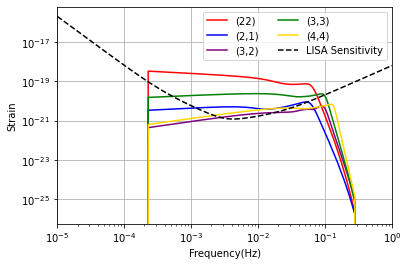

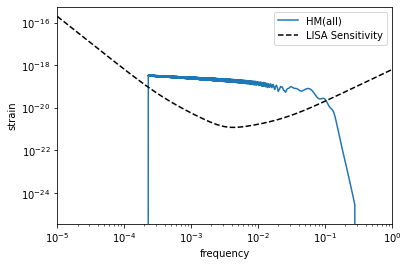

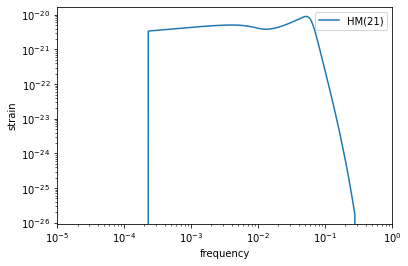

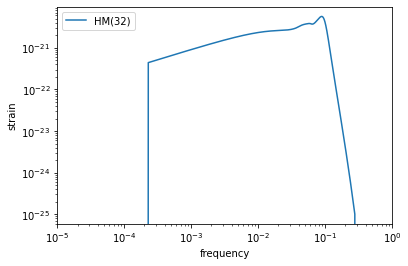

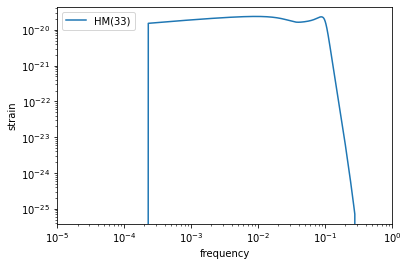

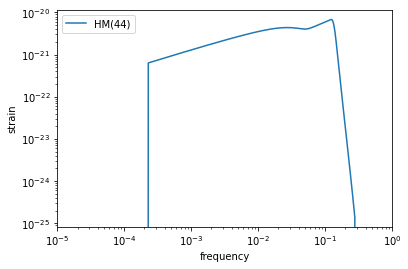

In [12]:
colors=['red','blue','purple','green','gold']

plt.loglog(hpf22.sample_frequencies,abs(hpf22)*hpf22.sample_frequencies,label='(22)',color=colors[0])
plt.loglog(hpf_HM21_rescale.sample_frequencies,abs(hpf_HM21_rescale)*hpf_HM21_rescale.sample_frequencies,label='(2,1)',color=colors[1])
plt.loglog(hpf_HM32_rescale.sample_frequencies,abs(hpf_HM32_rescale)*hpf_HM32_rescale.sample_frequencies,label='(3,2)',color=colors[2])
plt.loglog(hpf_HM33_rescale.sample_frequencies,abs(hpf_HM33_rescale)*hpf_HM33_rescale.sample_frequencies,label='(3,3)',color=colors[3])
plt.loglog(hpf_HM44_rescale.sample_frequencies,abs(hpf_HM44_rescale)*hpf_HM44_rescale.sample_frequencies,label='(4,4)',color=colors[4])
plt.loglog(fre,np.sqrt(fre*lisasen),linestyle='--',color='black',label='LISA Sensitivity')
plt.xlim(1e-5,1)
#plt.ylim(1e-22,1e-17)
plt.legend(ncol=2)
plt.grid()
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.savefig('characteristic_strain.pdf',dpi=300)
plt.show()

###############################################
hpf_HMall= hpf22 +hpf_HM21_rescale +hpf_HM32_rescale + hpf_HM33_rescale +hpf_HM44_rescale
plt.loglog(hpf_HMall.sample_frequencies,abs(hpf_HMall)*hpf_HMall.sample_frequencies,label='HM(all)')
plt.loglog(fre,np.sqrt(fre*lisasen),linestyle='--',color='black',label='LISA Sensitivity')
plt.legend()
plt.xlim(1e-5,1)
plt.xlabel('frequency')
plt.ylabel('strain')
plt.show()



plt.loglog(hpf_HM21_rescale.sample_frequencies,abs(hpf_HM21_rescale)*hpf_HM21_rescale.sample_frequencies,label='HM(21)')
plt.legend()
plt.xlim(1e-5,1)
plt.xlabel('frequency')
plt.ylabel('strain')
plt.show()
plt.loglog(hpf_HM32_rescale.sample_frequencies,abs(hpf_HM32_rescale)*hpf_HM32_rescale.sample_frequencies,label='HM(32)')
plt.legend()
plt.xlim(1e-5,1)
plt.xlabel('frequency')
plt.ylabel('strain')
plt.show()
plt.loglog(hpf_HM33_rescale.sample_frequencies,abs(hpf_HM33_rescale)*hpf_HM33_rescale.sample_frequencies,label='HM(33)')
plt.legend()
plt.xlim(1e-5,1)
plt.xlabel('frequency')
plt.ylabel('strain')
plt.show()
plt.loglog(hpf_HM44_rescale.sample_frequencies,abs(hpf_HM44_rescale)*hpf_HM44_rescale.sample_frequencies,label='HM(44)')
plt.legend()
plt.xlim(1e-5,1)
plt.xlabel('frequency')
plt.ylabel('strain')
plt.show()

2 2
0.5 0.0
(0.2791453714287147+0j)
0.2767821378329212j


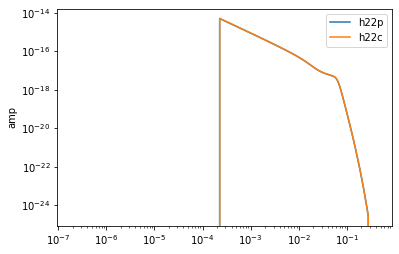

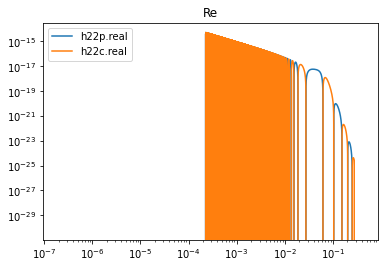

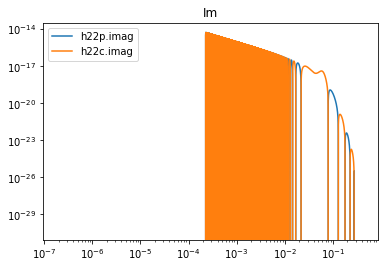

In [13]:

def htilde_lm(hp,l,m,inc,phi0):
    factorp=1/2.* (lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,m)+\
                 (-1)**l *np.conj(lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,-m)))
    print(factorp)
    hlm = hp/factorp
    return hlm
def htilde_lmc(hc,l,m,inc,phi0):
    factorc=1j/2.* (lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,m) - \
        (-1)**l *np.conj(lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,-m)))
    print(factorc)
    hlm = hc/factorc
    return hlm
l,m = modes[1][0]
print(l,m)

#plt.loglog(hpf22.sample_frequencies,abs(hpf22)*hpf22.sample_frequencies,label='hp')
#plt.loglog(hcf22.sample_frequencies,abs(hcf22)*hcf22.sample_frequencies,label='hc')
print(inc,phi0)
h22p=htilde_lm(hpf22,l,m,inc,phi0)
h22c= htilde_lmc(hcf22,l,m,inc,phi0)

plt.loglog(h22p.sample_frequencies,abs(h22p),label='h22p')
plt.loglog(h22c.sample_frequencies,abs(h22c),label='h22c')
plt.ylabel('amp')
plt.legend()
plt.show()



plt.loglog(h22p.sample_frequencies,h22p.real(),label='h22p.real')
plt.loglog(h22c.sample_frequencies,h22c.real(),label='h22c.real')
plt.legend()
plt.title('Re')
plt.show()

plt.loglog(h22p.sample_frequencies,h22p.imag(),label='h22p.imag')
plt.loglog(h22c.sample_frequencies,h22c.imag(),label='h22c.imag')
plt.legend()
plt.title('Im')
plt.show()

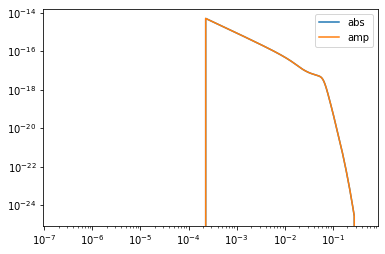

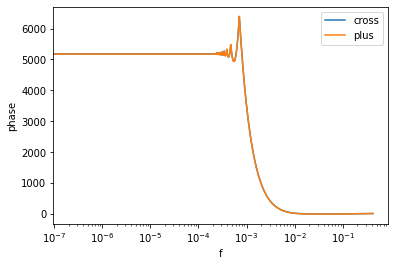

In [14]:
phasep = phase_from_frequencyseries(h22p)
phasec = phase_from_frequencyseries(h22c)
amp = amplitude_from_frequencyseries(h22p)


plt.loglog(h22p.sample_frequencies,abs(h22p),label='abs')
plt.loglog(amp.sample_frequencies,amp,label='amp')
plt.legend()
plt.show()

plt.semilogx(phasec.sample_frequencies,-phasec+phasec[-1],label='cross')
plt.semilogx(phasep.sample_frequencies,-phasep+phasep[-1],label='plus')
plt.ylabel('phase')
plt.xlabel('f')
plt.legend()
plt.show()




2 2
(0.2791453714287147+0j)
2 1
(0.15120677104241206+0j)
3 2
(0.20162803299385518+0j)
3 3
(-0.1939372545611808+0j)
4 4
(0.1138749076178247+0j)
2 2
2 1
3 2
3 3
4 4


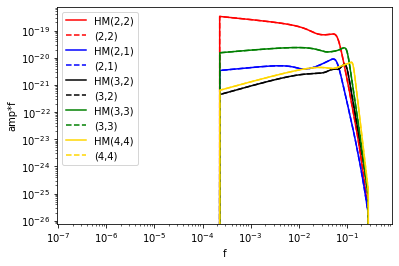

2 2
2 1
3 2
3 3
4 4


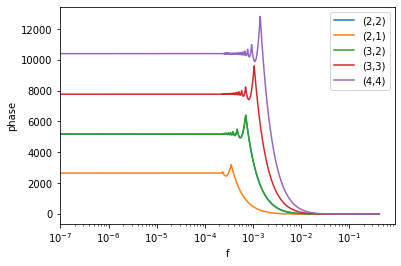

In [16]:
hlm={}
hplus={}
hplus[2,2]= hpf22
hplus[2,1]= hpf_HM21_rescale
hplus[3,2]= hpf_HM32_rescale
hplus[3,3]= hpf_HM33_rescale
hplus[4,4]= hpf_HM44_rescale
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tmp_htilde=htilde_lm(hplus[l,m],l,m,inc,phi0)
    tmp_amp= amplitude_from_frequencyseries(tmp_htilde)
    tmp_phase= phase_from_frequencyseries(tmp_htilde,remove_start_phase=False)
    hlm[l,m]=(tmp_amp,tmp_phase)


# l,m= modes[1][2]
# print(l,m)
# tmp_amp= abs(hlm[l,m][0])
# tmp_phase =hlm[l,m][1]
# print(tmp_phase)
# tmp_htilde=htilde_lm(hplus[l,m],l,m,inc,phi0)
# plt.loglog(tmp_amp.sample_frequencies,tmp_htilde-tmp_amp*np.exp(1j*tmp_phase))
# plt.legend()
# plt.xlabel('f')
# plt.ylabel('htilde-amp*exp(1j*phase)')
# plt.show()
# factor=1/2.* (lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,m)+\
#                  (-1)**l *np.conj(lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,-m)))
# print(factor)

#plt.loglog(hpf22.sample_frequencies,abs(hpf22)*hpf22.sample_frequencies,label='HM(22)')

# plt.loglog(tmp_phase.sample_frequencies,abs(hplus[l,m]-tmp_amp*factor*np.exp(1j*tmp_phase))*tmp_phase.sample_frequencies,label='(%d,%d)'%(l,m))
# plt.legend()
# plt.xlabel('f')
# plt.ylabel('(hp-factor*amp*exp(1j*phase))*f')
# plt.show()
##################################################
colors=['red','blue','black','green','gold']
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tmp_amp= abs(hlm[l,m][0])
    tmp_phase =hlm[l,m][1]
    factor=1/2.* (lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,m)+\
                 (-1)**l *np.conj(lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,-m)))
    plt.loglog(hplus[l,m].sample_frequencies,abs(hplus[l,m])*hplus[l,m].sample_frequencies,label='HM(%d,%d)'%(l,m),color=colors[i],linestyle='-')
    plt.loglog(tmp_phase.sample_frequencies,abs(tmp_amp*factor*np.exp(1j*tmp_phase))*tmp_phase.sample_frequencies,label='(%d,%d)'%(l,m),color=colors[i],linestyle='--')
    # plt.legend()
    # plt.ylabel('amp*f')
    # plt.xlabel('f')
    # plt.show()
    # plt.loglog(tmp_amp.sample_frequencies,(abs(hplus[l,m]-tmp_amp*factor*np.exp(1j*tmp_phase)))*tmp_amp.sample_frequencies,label='hplus-amp*exp(1j*phase)[%d,%d]'%(l,m))
    # plt.xlabel('f')
    # plt.ylabel('error')
    # plt.legend()
    # plt.show()


plt.legend()
plt.ylabel('amp*f')
plt.xlabel('f')
plt.show()
#################################################
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tmp_amp= abs(hlm[l,m][0])
    tmp_phase =hlm[l,m][1]
    plt.semilogx(tmp_phase.sample_frequencies,-tmp_phase+tmp_phase[-1],label='(%d,%d)'%(l,m))
plt.legend()
plt.ylabel('phase')
plt.xlabel('f')
plt.show()

# l,m= modes[1][0]
# print(l,m)
# tmp_amp= abs(hlm[l,m][0])
# tmp_phase =hlm[l,m][1]
# plt.semilogx(tmp_phase.sample_frequencies,-tmp_phase+tmp_phase[-1],label='(%d,%d)'%(l,m))
# l,m= modes[1][2]
# print(l,m)
# tmp_amp= abs(hlm[l,m][0])
# tmp_phase =hlm[l,m][1]
# plt.semilogx(tmp_phase.sample_frequencies,-tmp_phase+tmp_phase[-1],label='(%d,%d)'%(l,m))





2 2
(0.2791453714287147+0j)
2 1
(0.15120677104241206+0j)
3 2
(0.20162803299385518+0j)
3 3
(-0.1939372545611808+0j)
4 4
(0.1138749076178247+0j)


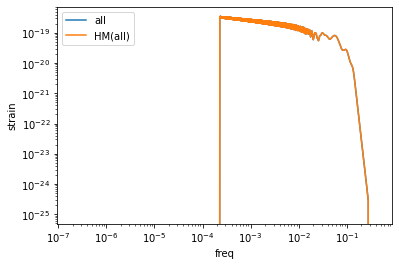

Text(0.5, 0, 'freq')

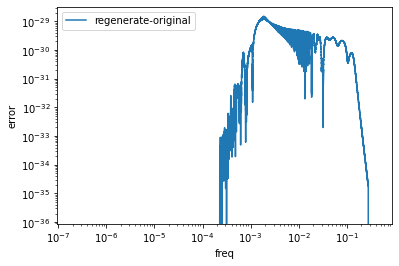

In [17]:
tmp_hp= 0+ 0j 
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    tmp_amp= hlm[l,m][0]
    tmp_phase =hlm[l,m][1]
    #tmp_phase = -tmp_phase+tmp_phase[-1]
    factor=1/2.* (lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,m)+\
                 (-1)**l *np.conj(lal.SpinWeightedSphericalHarmonic(inc,phi0,-2,l,-m)))
    print(factor)
    tmp_hp += factor*tmp_amp*np.exp(1j*tmp_phase)
plt.loglog(tmp_hp.sample_frequencies,abs(tmp_hp)*tmp_hp.sample_frequencies,label='all')
plt.loglog(hpf_HMall.sample_frequencies,abs(hpf_HMall)*hpf_HMall.sample_frequencies,label='HM(all)')
plt.xlabel('freq')
plt.ylabel('strain')
plt.legend()
plt.show()


plt.loglog(tmp_hp.sample_frequencies,abs(tmp_hp-hpf_HMall)*tmp_hp.sample_frequencies,label='regenerate-original')
plt.legend()
plt.ylabel('error')
plt.xlabel('freq')

generate TDI XYZ/AET

In [18]:
MfCUT_PhenomD = 0.5
Ms = (m1 + m2) * MTSUN_SI
fCUT_PhD = MfCUT_PhenomD/Ms
print(fCUT_PhD)

0.4614214625386419


In [19]:
wftdiXYZ={}
# t0=0.6
# psi=0.2

minindex=0
for i in range(len(modes[1])):
    l,m= modes[1][i]
    #print(l,m)
    tmp_phase =hlm[l,m][1]
    tmp_minindex = np.argmax(-tmp_phase+tmp_phase[-1])
    minindex = max(tmp_minindex,minindex)
    print(tmp_amp.sample_frequencies[minindex])
#freq = logsampling(tmp_phase.sample_frequencies[minindex],tmp_phase.sample_frequencies[-1],1000)
freq = logsampling(tmp_phase.sample_frequencies[minindex],fCUT_PhD,5000)
for i in range(len(modes[1])):
    l,m= modes[1][i]
    #print(l,m)
    tmp_amp= hlm[l,m][0]
    tmp_phase =hlm[l,m][1]
    maxindex = np.argmax(-tmp_phase+tmp_phase[-1])
    print(tmp_amp.sample_frequencies[maxindex])
    tmp_freq = logsampling(tmp_phase.sample_frequencies[maxindex],tmp_phase.sample_frequencies[-1],1000)
    wf = [tmp_phase.sample_frequencies,tmp_amp,-tmp_phase+tmp_phase[-1]]
    wftdiXYZ[l,m]= get_fd_LISATDI(freq,wf,inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict, TDItag='TDIXYZ')

wftdiAET={}
for i in range(len(modes[1])):
    l,m= modes[1][i]
    #print(l,m)
    tmp_amp= hlm[l,m][0]
    tmp_phase =hlm[l,m][1]
    maxindex = np.argmax(-tmp_phase+tmp_phase[-1])
    print(tmp_amp.sample_frequencies[maxindex])
    tmp_freq = logsampling(tmp_phase.sample_frequencies[maxindex],tmp_phase.sample_frequencies[-1],2000)
    wf = [tmp_phase.sample_frequencies,tmp_amp,-tmp_phase+tmp_phase[-1]]
    wftdiAET[l,m]= get_fd_LISATDI(freq,wf,inc,lambd,beta,psi,phi0,[[l,m]],t0=t0, trajdict=trajdict, TDItag='TDIAET')



0.000705
0.000705
0.000705
0.0010576
0.0014102
0.000705
0.0003526
0.000705
0.0010576
0.0014102
0.000705
0.0003526
0.000705
0.0010576
0.0014102


2 2
2 1
3 2
3 3
4 4


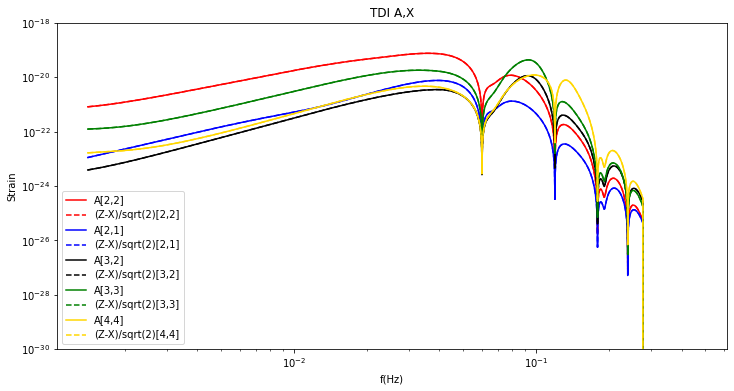

2 2
2 1
3 2
3 3
4 4


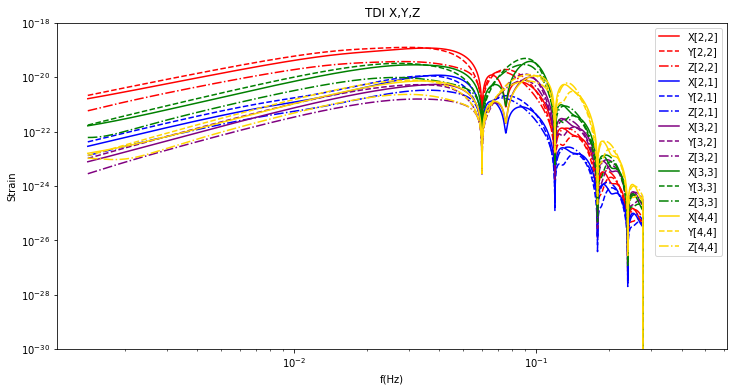

2 2
2 1
3 2
3 3
4 4


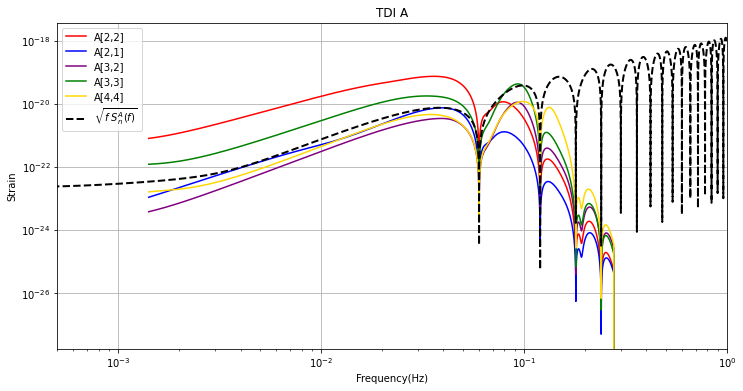

In [20]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
fre = logsampling(1e-5,1.0,200)
PSD_TDIX= noisepsd_X(fre)
#plt.loglog(fre,np.sqrt(PSD_TDIX*fre),label='psd X')
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI1'])*wftdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='-',color=colors[i])
    plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI3']-wftdiXYZ[l,m]['TDI1'])/np.sqrt(2)*wftdiXYZ[l,m]['freq'],label='(Z-X)/sqrt(2)[%d,%d]'%(l,m),linestyle='--',color=colors[i])
    #plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI2'])*wftdiXYZ[l,m]['freq'],label='Y[%d,%d]'%(l,m),linestyle='--',color=colors[i])
    #plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI3'])*wftdiXYZ[l,m]['freq'],label='Z[%d,%d]'%(l,m),linestyle='-.',color=colors[i])
plt.xlabel('f(Hz)')
plt.ylabel('Strain')
plt.ylim(1e-30,1e-18)
plt.title('TDI A,X')
plt.legend()
plt.show()


f, ax = plt.subplots(1, 1, figsize=[12,6])
colors=['red','blue','purple','green','gold']
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    #plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI1'])*wftdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='-',color=colors[i])
    plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI1'])*wftdiXYZ[l,m]['freq'],label='X[%d,%d]'%(l,m),linestyle='-',color=colors[i])
    plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI2'])*wftdiXYZ[l,m]['freq'],label='Y[%d,%d]'%(l,m),linestyle='--',color=colors[i])
    plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI3'])*wftdiXYZ[l,m]['freq'],label='Z[%d,%d]'%(l,m),linestyle='-.',color=colors[i])
plt.xlabel('f(Hz)')
plt.ylabel('Strain')
plt.ylim(1e-30,1e-18)
plt.title('TDI X,Y,Z')
plt.legend()
plt.show()

f, ax = plt.subplots(1, 1, figsize=[12,6])

for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI1'])*wftdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='-',color=colors[i])
    #plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI2'])*wftdiAET[l,m]['freq'],label='E[%d,%d]'%(l,m),linestyle='--',color=colors[i])
    #plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI3'])*wftdiAET[l,m]['freq'],label='T[%d,%d]'%(l,m),linestyle='-.',color=colors[i])
    #plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI2'])*wftdiXYZ[l,m]['freq'],label='X[%d,%d]'%(l,m),linestyle='--',color=colors[i])
plt.loglog(PSD_TDIAE.sample_frequencies,np.sqrt(PSD_TDIAE*PSD_TDIAE.sample_frequencies),linestyle='--',linewidth=2,color='black',label='$\sqrt{f\ S^{A}_{n}(f)}$')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.xlim(5e-4,1e0)
#plt.ylim(1e-30,1e-18)
plt.title('TDI A')
plt.legend()
plt.grid()
plt.savefig('TDI_characteristic_strain.pdf',dpi=300)
plt.show()

In [21]:
#sum of all modes
TDIA= np.zeros(len(freq), dtype='complex128')
TDIE= np.zeros(len(freq), dtype='complex128')
TDIT= np.zeros(len(freq), dtype='complex128')
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    TDIA += wftdiAET[l,m]['TDI1']
    TDIE += wftdiAET[l,m]['TDI2']
    TDIT += wftdiAET[l,m]['TDI3']

    


2 2
2 1
3 2
3 3
4 4


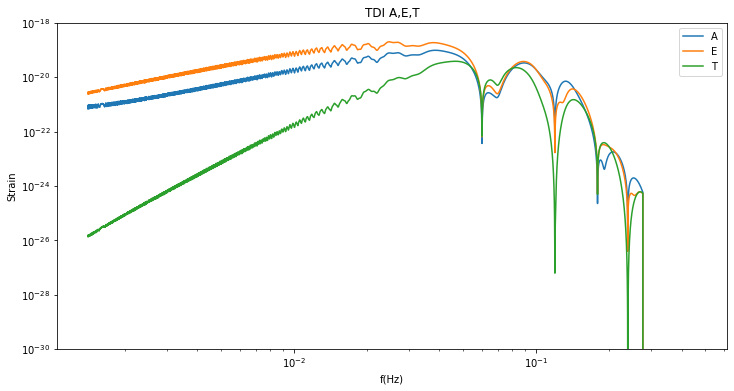

In [22]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
plt.loglog(freq,np.abs(TDIA*freq),label='A',linestyle='-')
plt.loglog(freq,np.abs(TDIE*freq),label='E',linestyle='-')
plt.loglog(freq,np.abs(TDIT*freq),label='T',linestyle='-')

plt.xlabel('f(Hz)')
plt.ylabel('Strain')
plt.ylim(1e-30,1e-18)
plt.title('TDI A,E,T')
plt.legend()
plt.show()

In [23]:
L= 2.5e9/LC.c
#we have eliminated frequency-dependent prefactors that are common to the signal 
# and to the noise by introducing the rescalings
TDIa = np.exp(-1j*(2*np.pi*freq*L))/(1j*np.sqrt(2)*np.sin(2*np.pi*freq*L)) *TDIA
TDIe = np.exp(-1j*(2*np.pi*freq*L))/(1j*np.sqrt(2)*np.sin(2*np.pi*freq*L)) *TDIE
TDIt = np.exp(-1j*(3*np.pi*freq*L))/(2*np.sqrt(2)*np.sin(np.pi*freq*L)*np.sin(2*np.pi*freq*L)) *TDIT

TDIa = TDIa/(-1j*6*np.pi*freq*L)
TDIe = TDIe/(-1j*6*np.pi*freq*L)
TDIt = TDIt/(-1j*6*np.pi*freq*L)


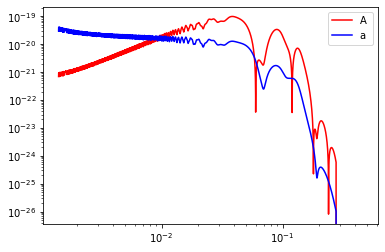

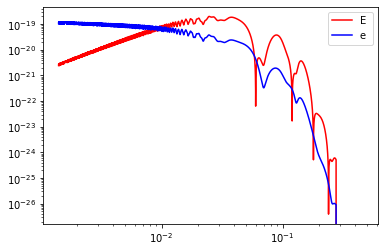

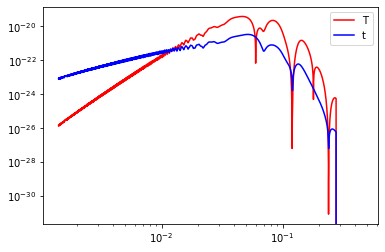

In [24]:
plt.loglog(freq,np.abs(TDIA*freq),label='A',color='red')
plt.loglog(freq,np.abs(TDIa*freq),label='a ',color='blue')
plt.legend()
plt.show()

plt.loglog(freq,np.abs(TDIE*freq),label='E',color='red')
plt.loglog(freq,np.abs(TDIe*freq),label='e ',color='blue')
plt.legend()
plt.show()

plt.loglog(freq,np.abs(TDIT*freq),label='T',color='red')
plt.loglog(freq,np.abs(TDIt*freq),label='t ',color='blue')
plt.legend()
plt.show()



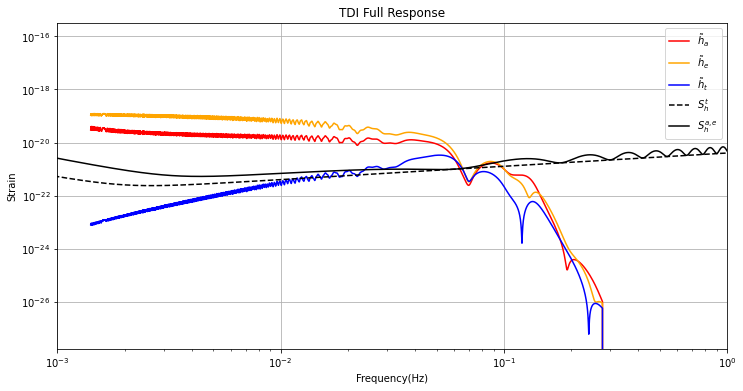

In [25]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
plt.loglog(freq,np.abs(TDIa*freq),label='$\\tilde{h}_a$',color='red',linestyle='-')
plt.loglog(freq,np.abs(TDIe*freq),label='$\\tilde{h}_e$',color='orange',linestyle='-')
plt.loglog(freq,np.abs(TDIt*freq),label='$\\tilde{h}_t$',color='blue',linestyle='-')
plt.loglog(PSD_TDIt.sample_frequencies,np.sqrt(PSD_TDIt*PSD_TDIt.sample_frequencies),linestyle='--',color='black',label='$S^{t}_{h}$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),linestyle='-',color='black',label='$S^{a,e}_{h}$')

plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.xlim(1e-3,1e-0)
#plt.ylim(1e-30,1e-18)
plt.title('TDI Full Response')
plt.legend()
plt.grid()
plt.savefig('TDI_FR_characteristic_strain.pdf',dpi=300)
plt.show()

In [26]:
palette = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]
def plot_wf_tdi_all(wf, scalebyf2=False):
    fig, ax = plt.subplots(3, 3, figsize=(16,12))
    f, amp, phase, phaseRdelay, transferL1, transferL2, transferL3, TDI1, TDI2, TDI3, TDItag = wf['freq'], wf['amp'], wf['phase'], wf['phaseRdelay'], wf['transferL1'], wf['transferL2'], wf['transferL3'], wf['TDI1'], wf['TDI2'], wf['TDI3'], wf['TDItag']
    # Common settings
    for i in range(3):
        for j in range(3):
            ax[i][j].set_xlim(min(f), max(f))
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlabel(r'f (Hz)')
            ax[i][j].grid()
    # Amp
    ax[0][0].plot(f, amp, color=palette[0])
    ax[0][0].set_yscale('log')
    ax[0][0].set_ylabel(r'$A_{22}$')
    ax[0][0].set_title(r'Amplitude')
    # Phase
    ax[0][1].plot(f, phase, color=palette[0])
    ax[0][1].set_xscale('log')
    ax[0][1].set_ylabel(r'$\Phi_{22}$')
    ax[0][1].set_title(r'Phase')
    # Orbital delay phase
    ax[0][2].plot(f, phaseRdelay, color=palette[0])
    ax[0][2].set_xscale('log')
    ax[0][2].axhline(0, color='k')
    ax[0][2].set_ylabel(r'$\Phi_{d_0}$')
    ax[0][2].set_title(r'Orbital delay phase')
    # TDI and transfer
    transL = {}
    if scalebyf2:
        fstar = C_SI/L_SI
        transL[1], transL[2], transL[3] = transferL1*(fstar/f)**2, transferL2*(fstar/f)**2, transferL3*(fstar/f)**2
    else:
        transL[1], transL[2], transL[3] = transferL1, transferL2, transferL3
    tdi = {}
    tdi[1], tdi[2], tdi[3] = TDI1, TDI2, TDI3
    # Labels
    tdilabel = {}
    if TDItag=='TDIXYZ':
        tdilabel[1] = 'X'
        tdilabel[2] = 'Y'
        tdilabel[3] = 'Z'
    elif TDItag=='TDIAET':
        tdilabel[1] = 'A'
        tdilabel[2] = 'E'
        tdilabel[3] = 'T'
    else:
        raise ValueError("Error in plot_wf_tdi: TDItag not recognized.")
    ylabeltrans = {}; titletrans = {}; ylabeltdi = {}; titletdi = {};
    for i in range(1,4):
        if scalebyf2:
            ylabeltrans[i] = r'$(f_{*}/f)^2\mathcal{T}^L_'+tdilabel[i]+'$'
        else:
            ylabeltrans[i] = r'$\mathcal{T}^L_'+tdilabel[i]+'$'
        titletrans[i] = r'Transfer '+tdilabel[i]+' Re/Im'
        ylabeltdi[i] = r'$\mathrm{TDI}_'+tdilabel[i]+'$'
        titletdi[i] = r'TDI '+tdilabel[i]+' Re/Im'
    # Plot transfer
    for i in range(1,4):
        ax[1][i-1].plot(f, np.real(transL[i]), color=palette[0],label='Re')
        ax[1][i-1].plot(f, np.imag(transL[i]), color=palette[1],label='Im')
        ax[1][i-1].axhline(0, color='k')
        ax[1][i-1].set_ylabel(ylabeltrans[i])
        ax[1][i-1].set_title(titletrans[i])
        ax[1][i-1].legend()
    # Plot TDI
    for i in range(1,4):
        ax[2][i-1].plot(f, np.real(tdi[i]), color=palette[0],label='Re')
        ax[2][i-1].plot(f, np.imag(tdi[i]), color=palette[1],label='Im')
        ax[2][i-1].axhline(0, color='k')
        ax[2][i-1].set_ylabel(ylabeltdi[i])
        ax[2][i-1].set_title(titletdi[i])
        ax[2][i-1].legend()
    plt.tight_layout()
    plt.show()

In [27]:
# Computing given TDI channel by interpolation
def func_wfTDI(freqs, wfTDI):
    res = np.zeros(len(freqs), dtype=complex)
    wftdi = {}
    wftdi['TDItag'] = wfTDI['TDItag']
    wftdi['t0'] = wfTDI['t0']
    #####################
    fbeg = max(freqs[0], wfTDI['freq'][0])
    fend = min(freqs[-1], wfTDI['freq'][-1])
    ibeg = np.where(freqs>=fbeg)[0][0]
    iend = np.where(freqs<=fend)[0][-1]
    fs = freqs[ibeg:iend+1]
    n=len(fs)
    t0 = wfTDI['t0'] # will be used to apply timeshift
    ampspline = spline(wfTDI['freq'], wfTDI['amp'])
    phasespline = spline(wfTDI['freq'], wfTDI['phase'])
    phaseRdelayspline = spline(wfTDI['freq'], wfTDI['phaseRdelay'])
    amp = ampspline(fs)
    phase = phasespline(fs)
    phaseRdelay = phaseRdelayspline(fs)
    wftdi['freq'] = np.copy(fs)
    wftdi['amp'] = np.copy(amp)
    wftdi['phase'] = np.copy(phase)
    wftdi['phaseRdelay'] = np.copy(phaseRdelay)
    #wftdi['transferL1'] = np.zeros(n, dtype=np.complex128)
    #wftdi['transferL2'] = np.zeros(n, dtype=np.complex128)
    #wftdi['transferL3'] = np.zeros(n, dtype=np.complex128)

    for chan in [1,2,3]:
        keytransfer = 'transferL'+str(chan)
        transferLRespline = spline(wfTDI['freq'], np.real(wfTDI[keytransfer]))
        transferLImspline = spline(wfTDI['freq'], np.imag(wfTDI[keytransfer]))
        transferLRe = transferLRespline(fs)
        transferLIm = transferLImspline(fs)
        wftdi[keytransfer]= transferLRe+1j*transferLIm 
        phasetimeshift = 2*pi*t0*fs
        phasetimeshift=0
        vals = (transferLRe+1j*transferLIm) * amp * np.exp(1j*(phase+phaseRdelay+phasetimeshift))
        res[ibeg:iend+1] = vals
        keyTDI = 'TDI' +str(chan)
        # TDIRespline = spline(wfTDI['freq'], np.real(wfTDI[keyTDI]))
        # TDIImspline = spline(wfTDI['freq'], np.imag(wfTDI[keyTDI]))
        # TDIRe = TDIRespline(fs)
        # TDIIm = TDIImspline(fs)
        # vals = TDIRe + 1j*TDIIm
        # res[ibeg:iend+1]= vals
        wftdi[keyTDI]= np.copy(res)

    
    

    
    return wftdi

In [28]:
print(freq[0],freq[-1])
maxfsignal = freq[-1] 
print(maxfsignal,1/2/maxfsignal)
dt_SMBH = 5
fsample_SMBH = 1./dt_SMBH
fnyquist_SMBH = 1./2*fsample_SMBH
print('Fs',fsample_SMBH)
print('fNy',fnyquist_SMBH)
df = 1/ 1e7

#n_SMBH = int(fnyquist_SMBH/df)+1
f0 = np.floor(freq[0]/df)*df
print(f0)
n_SMBH= int((freq[-1]-f0)/df)
print('df, num',df,n_SMBH) 
freqs_SMBH = df*np.arange(n_SMBH) +f0
print(len(freqs_SMBH))
freqs_SMBH = freqs_SMBH[(freqs_SMBH>=freq[0]) & (freqs_SMBH<=fnyquist_SMBH)]
print(len(freqs_SMBH))
print(freqs_SMBH[0], freqs_SMBH[-1])

0.0014102 0.4614214625386419
0.4614214625386419 1.083608025619587
Fs 0.2
fNy 0.1
0.0014102
df, num 1e-07 4600112
4600112
985899
0.0014102 0.09999999999999999


对单个模式进行插值

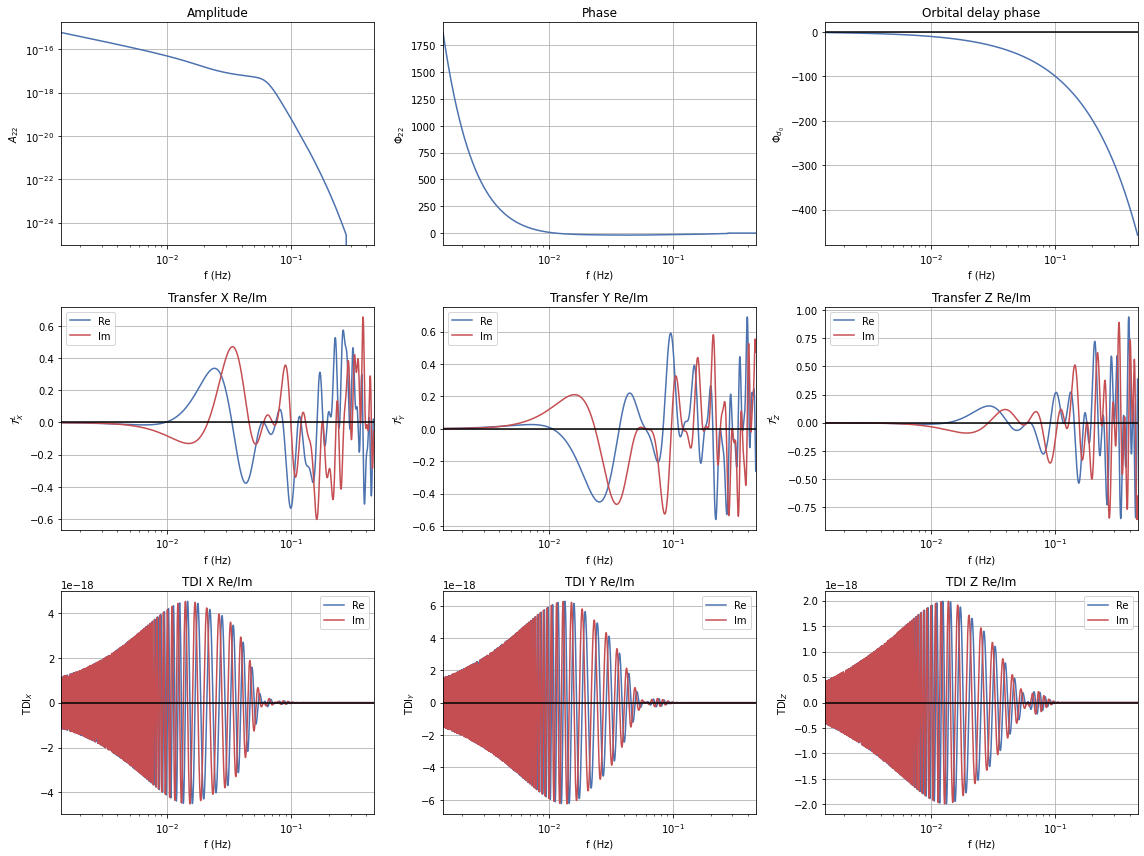

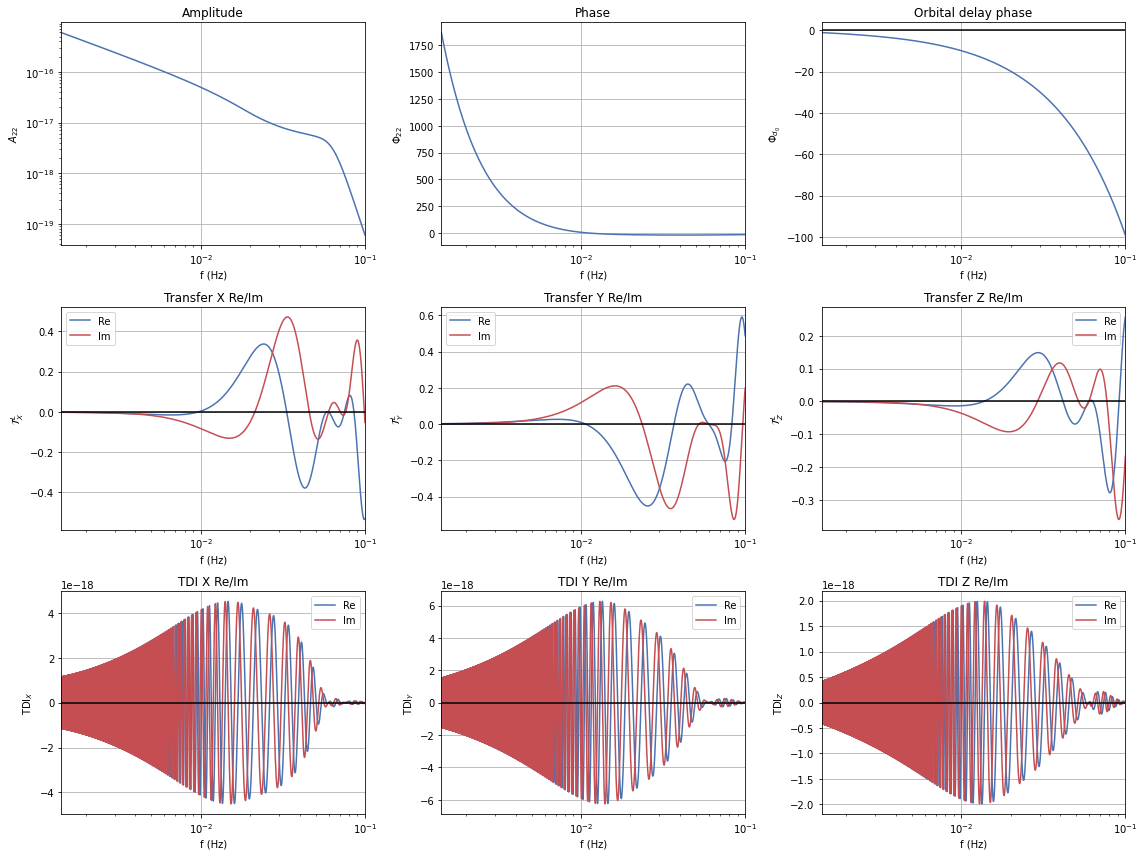

In [29]:
wftdiXYZ_int={}
l,m= 2, 2 
wftdiXYZ_int[l,m] = func_wfTDI(freqs_SMBH, wftdiXYZ[l,m])
plot_wf_tdi_all(wftdiXYZ[l,m], scalebyf2=False)
plot_wf_tdi_all(wftdiXYZ_int[l,m], scalebyf2=False)

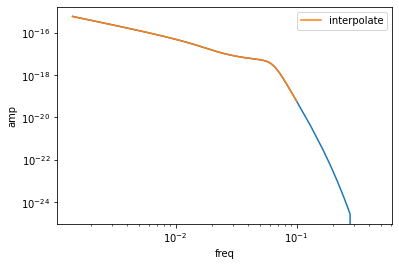

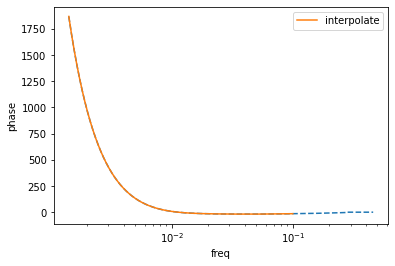

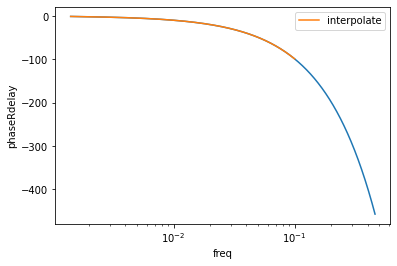

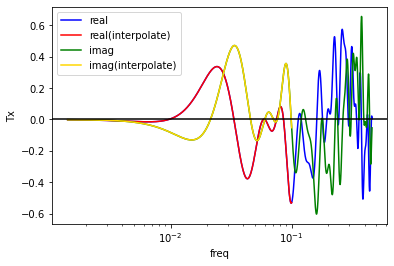

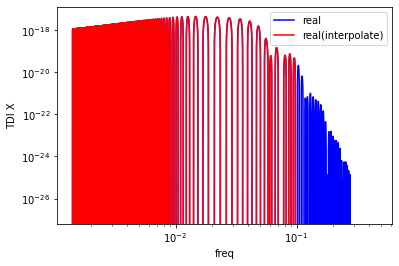

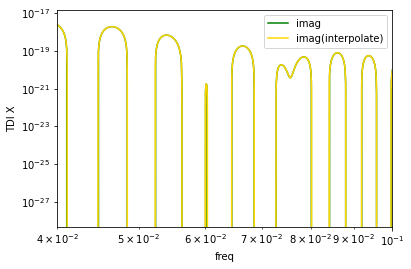

In [30]:
plt.loglog(wftdiXYZ[l,m]['freq'],wftdiXYZ[l,m]['amp'])
plt.loglog(wftdiXYZ_int[l,m]['freq'],wftdiXYZ_int[l,m]['amp'],label='interpolate')
plt.ylabel('amp')
plt.xlabel('freq')
plt.legend()
plt.show()
####################
plt.semilogx(wftdiXYZ[l,m]['freq'],wftdiXYZ[l,m]['phase'],linestyle='--')
plt.semilogx(wftdiXYZ_int[l,m]['freq'],wftdiXYZ_int[l,m]['phase'],label='interpolate')
plt.ylabel('phase')
plt.xlabel('freq')
plt.legend()
plt.show()
############################
plt.semilogx(wftdiXYZ[l,m]['freq'],wftdiXYZ[l,m]['phaseRdelay'])
plt.semilogx(wftdiXYZ_int[l,m]['freq'],wftdiXYZ_int[l,m]['phaseRdelay'],label='interpolate')
plt.ylabel('phaseRdelay')
plt.xlabel('freq')
plt.legend()
plt.show()

############################3
plt.semilogx(wftdiXYZ[l,m]['freq'],wftdiXYZ[l,m]['transferL1'].real,label='real',color='blue')
plt.semilogx(wftdiXYZ_int[l,m]['freq'],wftdiXYZ_int[l,m]['transferL1'].real,label='real(interpolate)',color='red')
plt.semilogx(wftdiXYZ[l,m]['freq'],wftdiXYZ[l,m]['transferL1'].imag,label='imag',color='green')
plt.semilogx(wftdiXYZ_int[l,m]['freq'],wftdiXYZ_int[l,m]['transferL1'].imag,label='imag(interpolate)',color='gold')
#plt.xlim(4e-2,1e-1)
plt.axhline(y=0,color='black')
plt.ylabel('Tx')
plt.xlabel('freq')
plt.legend()
plt.show()
###########################
plt.loglog(wftdiXYZ[l,m]['freq'],np.real(wftdiXYZ[l,m]['TDI1']),label='real',color='blue')
plt.loglog(wftdiXYZ_int[l,m]['freq'],np.real(wftdiXYZ_int[l,m]['TDI1']),label='real(interpolate)',color='red')
plt.ylabel('TDI X')
plt.xlabel('freq')
#plt.xlim(4e-2,1e-1)
#plt.ylim(-1e-20,1e-20)
plt.legend()
plt.show()


plt.loglog(wftdiXYZ[l,m]['freq'],wftdiXYZ[l,m]['TDI1'].imag,label='imag',color='green')
plt.loglog(wftdiXYZ_int[l,m]['freq'],wftdiXYZ_int[l,m]['TDI1'].imag,label='imag(interpolate)',color='gold')
plt.ylabel('TDI X')
plt.xlabel('freq')
plt.xlim(4e-2,1e-1)
#plt.ylim(-1e-20,1e-20)
plt.legend()
plt.show()


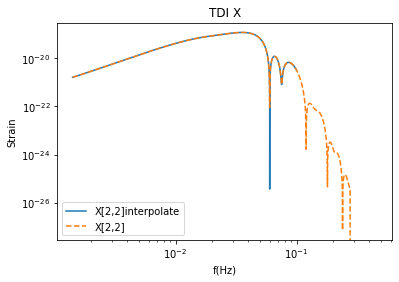

In [31]:
plt.loglog(freqs_SMBH,np.abs(wftdiXYZ_int[l,m]['TDI1']*freqs_SMBH),label='X[%d,%d]interpolate'%(l,m))
plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI1'])*wftdiXYZ[l,m]['freq'],label='X[%d,%d]'%(l,m),linestyle='--')

plt.xlabel('f(Hz)')
plt.ylabel('Strain')
#plt.xlim(5e-2,9e-2)
#plt.ylim(1e-30,1e-18)
plt.title('TDI X')
#plt.xlim(4e-2,8e-2)
plt.legend()
plt.show()

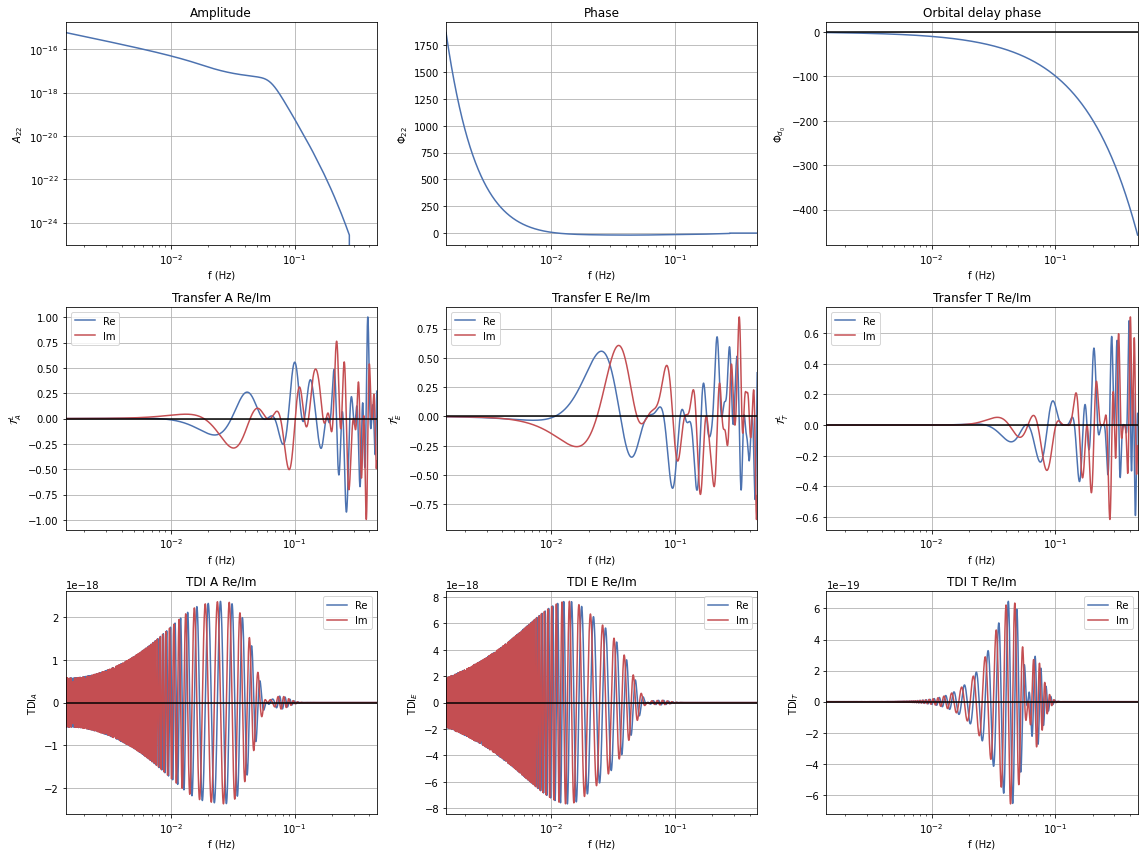

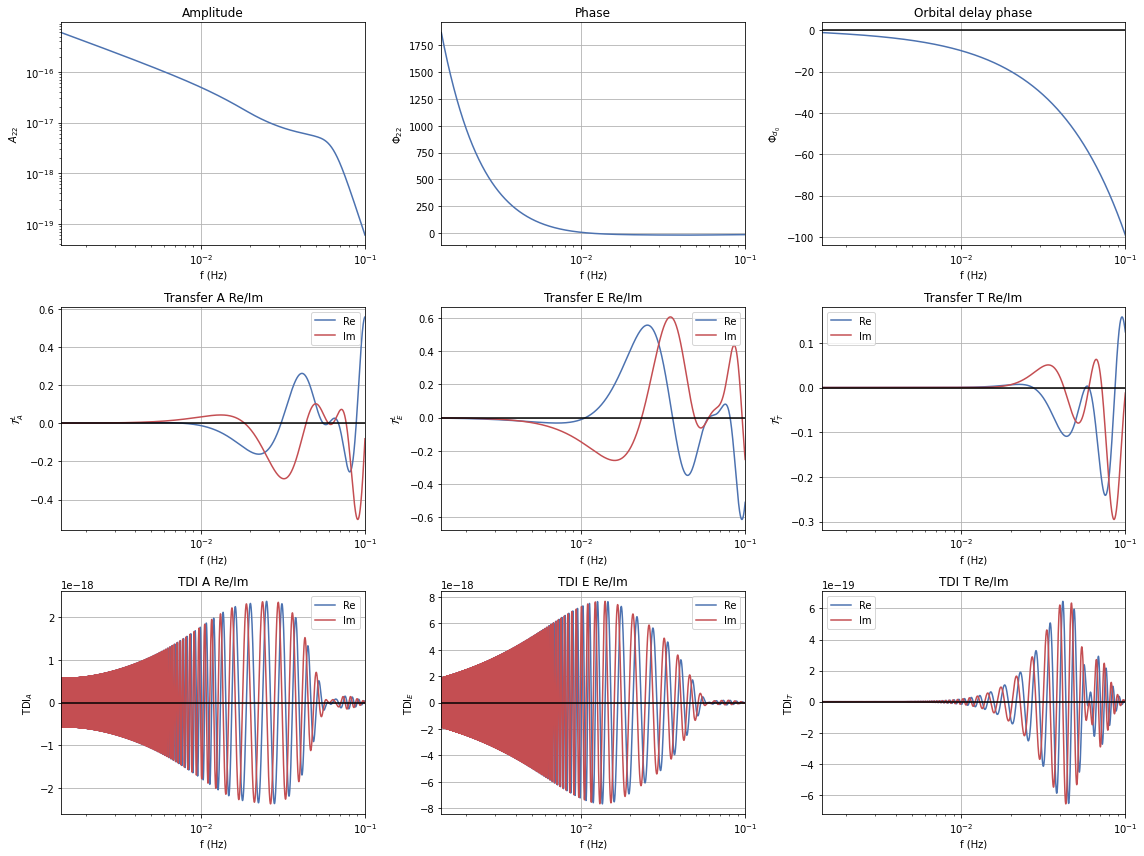

In [32]:
wftdiAET_int={}
l,m= 2, 2 
wftdiAET_int[l,m] = func_wfTDI(freqs_SMBH, wftdiAET[l,m])
plot_wf_tdi_all(wftdiAET[l,m], scalebyf2=False)
plot_wf_tdi_all(wftdiAET_int[l,m], scalebyf2=False)


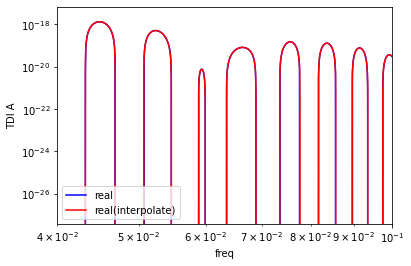

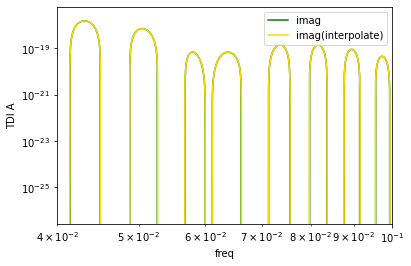

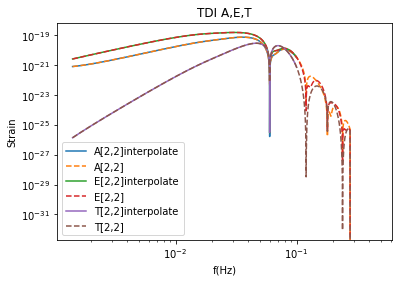

In [33]:
plt.loglog(wftdiAET[l,m]['freq'],np.real(wftdiAET[l,m]['TDI1']),label='real',color='blue')
plt.loglog(wftdiAET_int[l,m]['freq'],np.real(wftdiAET_int[l,m]['TDI1']),label='real(interpolate)',color='red')
plt.ylabel('TDI A')
plt.xlabel('freq')
plt.xlim(4e-2,1e-1)
#plt.ylim(-1e-20,1e-20)
plt.legend()
plt.show()


plt.loglog(wftdiAET[l,m]['freq'],wftdiAET[l,m]['TDI1'].imag,label='imag',color='green')
plt.loglog(wftdiAET_int[l,m]['freq'],wftdiAET_int[l,m]['TDI1'].imag,label='imag(interpolate)',color='gold')
plt.ylabel('TDI A')
plt.xlabel('freq')
plt.xlim(4e-2,1e-1)
#plt.ylim(-1e-20,1e-20)
plt.legend()
plt.show()


plt.loglog(freqs_SMBH,np.abs(wftdiAET_int[l,m]['TDI1']*freqs_SMBH),label='A[%d,%d]interpolate'%(l,m))
plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI1'])*wftdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='--')
plt.loglog(freqs_SMBH,np.abs(wftdiAET_int[l,m]['TDI2']*freqs_SMBH),label='E[%d,%d]interpolate'%(l,m))
plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI2'])*wftdiAET[l,m]['freq'],label='E[%d,%d]'%(l,m),linestyle='--')
plt.loglog(freqs_SMBH,np.abs(wftdiAET_int[l,m]['TDI3']*freqs_SMBH),label='T[%d,%d]interpolate'%(l,m))
plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI3'])*wftdiAET[l,m]['freq'],label='T[%d,%d]'%(l,m),linestyle='--')

plt.xlabel('f(Hz)')
plt.ylabel('Strain')
#plt.xlim(5e-2,9e-2)
#plt.ylim(1e-30,1e-18)
plt.title('TDI A,E,T')
#plt.xlim(5e-2,7e-2)
plt.legend()
plt.show()

如果对加和后的模式进行插值

对各个模式做插值

In [34]:
wftdiAET_int={}
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    wftdiAET_int[l,m] = func_wfTDI(freqs_SMBH, wftdiAET[l,m])
    

2 2
2 1
3 2
3 3
4 4


2 2


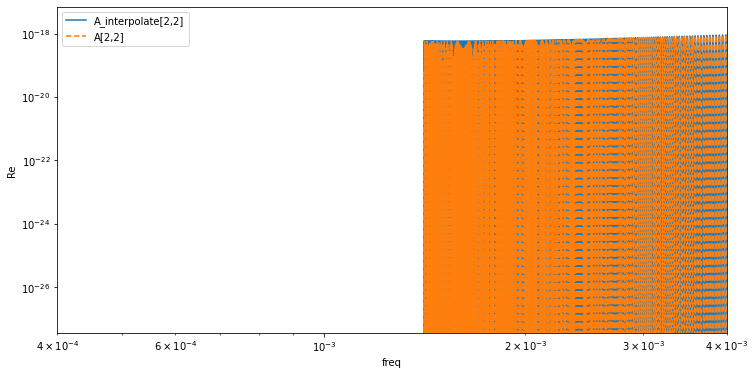

2 1


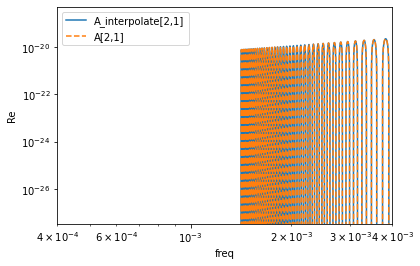

3 2


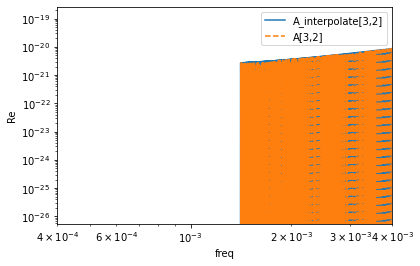

3 3


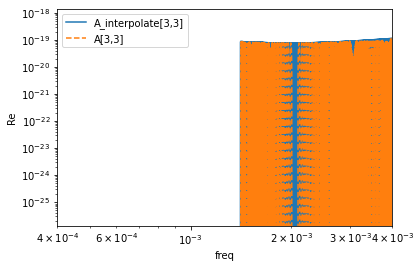

4 4


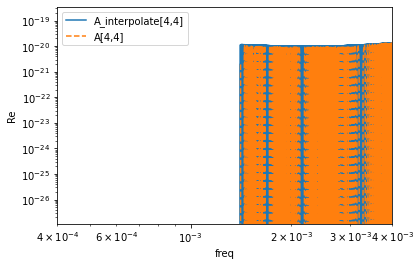

In [35]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    plt.loglog(wftdiAET_int[l,m]['freq'], wftdiAET_int[l,m]['TDI1'].real,label='A_interpolate[%d,%d]'%(l,m),linestyle='-')
    plt.loglog(wftdiAET[l,m]['freq'], wftdiAET[l,m]['TDI1'].real,label='A[%d,%d]'%(l,m),linestyle='--')
    plt.ylabel('Re')
    plt.xlabel('freq')
    plt.xlim(4e-4,4e-3)
    plt.legend()
    plt.show()
    #plt.loglog(wftdiAET_int[l,m]['freq'], np.abs(wftdiAET_int[l,m]['TDI1'])*wftdiAET_int[l,m]['freq'],label='A_interpolate[%d,%d]'%(l,m),linestyle='-',color=colors[i])
    #plt.loglog(wftdiAET[l,m]['freq'], np.abs(wftdiAET[l,m]['TDI1'])*wftdiAET[l,m]['freq'],label='A[%d,%d]'%(l,m),linestyle='--',color=colors[i])
    #plt.loglog(wftdiAET_int[l,m]['freq'], np.abs(wftdiAET_int[l,m]['TDI2'])*wftdiAET_int[l,m]['freq'],label='E_interpolate[%d,%d]'%(l,m),linestyle='--',color=colors[i])
    #plt.loglog(wftdiAET_int[l,m]['freq'], np.abs(wftdiAET_int[l,m]['TDI3'])*wftdiAET_int[l,m]['freq'],label='T_interpolate[%d,%d]'%(l,m),linestyle='-.',color=colors[i])
    #plt.loglog(wftdiXYZ[l,m]['freq'], np.abs(wftdiXYZ[l,m]['TDI2'])*wftdiXYZ[l,m]['freq'],label='X[%d,%d]'%(l,m),linestyle='--',color=colors[i])
# plt.xlabel('f(Hz)')
# plt.ylabel('Strain')
# plt.xlim(4e-4,2e-3)
# plt.ylim(1e-30,1e-18)
# plt.title('TDI A,E,T(interpolate)')
# plt.legend()
# plt.show()

In [36]:
#sum of all modes
TDIA_int= np.zeros(len(freqs_SMBH), dtype='complex128')
TDIE_int= np.zeros(len(freqs_SMBH), dtype='complex128')
TDIT_int= np.zeros(len(freqs_SMBH), dtype='complex128')
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    TDIA_int += wftdiAET_int[l,m]['TDI1']
    TDIE_int += wftdiAET_int[l,m]['TDI2']
    TDIT_int += wftdiAET_int[l,m]['TDI3']

2 2
2 1
3 2
3 3
4 4


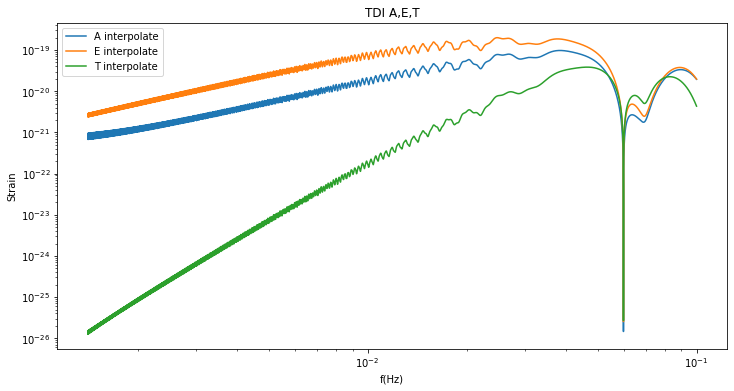

In [37]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
plt.loglog(freqs_SMBH,np.abs(TDIA_int*freqs_SMBH),label='A interpolate',linestyle='-')
#plt.loglog(freq,np.abs(TDIA*freq),label='A',linestyle='-')
plt.loglog(freqs_SMBH,np.abs(TDIE_int*freqs_SMBH),label='E interpolate',linestyle='-')
plt.loglog(freqs_SMBH,np.abs(TDIT_int*freqs_SMBH),label='T interpolate',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIE_int*freqs_SMBH),label='E',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIT_int*freqs_SMBH),label='T',linestyle='-')

plt.xlabel('f(Hz)')
plt.ylabel('Strain')
#plt.xlim(4e-4,2e-3)
#plt.ylim(1e-30,1e-18)
plt.title('TDI A,E,T')
plt.legend()
plt.show()

rescale the PSD

In [39]:
f_L= LC.c/2.5e9


In [38]:
L= 2.5e9/LC.c
#we have eliminated frequency-dependent prefactors that are common to the signal 
# and to the noise by introducing the rescalings
TDIa = np.exp(-1j*(2*np.pi*freqs_SMBH*L))/(1j*np.sqrt(2)*np.sin(2*np.pi*freqs_SMBH*L)) *TDIA_int
TDIe = np.exp(-1j*(2*np.pi*freqs_SMBH*L))/(1j*np.sqrt(2)*np.sin(2*np.pi*freqs_SMBH*L)) *TDIE_int
TDIt = np.exp(-1j*(3*np.pi*freqs_SMBH*L))/(2*np.sqrt(2)*np.sin(np.pi*freqs_SMBH*L)*np.sin(2*np.pi*freqs_SMBH*L)) *TDIT_int

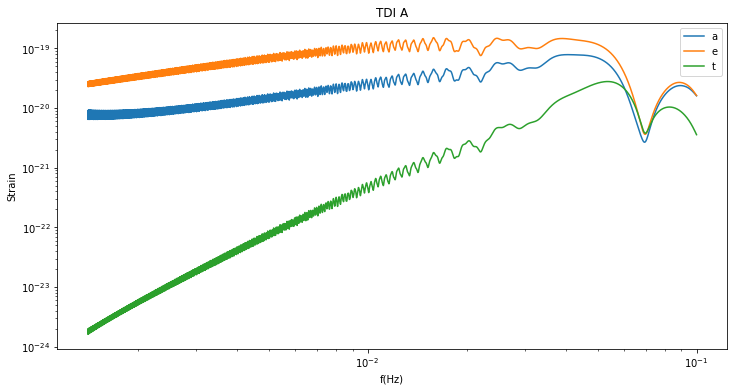

In [40]:
f, ax = plt.subplots(1, 1, figsize=[12,6])
#plt.loglog(freqs_SMBH,np.abs(TDIA_int*freqs_SMBH),label='A',linestyle='-')
plt.loglog(freqs_SMBH,np.abs(TDIa*freqs_SMBH),label='a',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIE_int*freqs_SMBH),label='E',linestyle='-')
plt.loglog(freqs_SMBH,np.abs(TDIe*freqs_SMBH),label='e',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIT_int*freqs_SMBH),label='T',linestyle='-')
plt.loglog(freqs_SMBH,np.abs(TDIt*freqs_SMBH),label='t',linestyle='-')
#plt.loglog(freq,np.abs(TDIA*freq),label='A',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIE_int*freqs_SMBH),label='E interpolate',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIT_int*freqs_SMBH),label='T interpolate',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIE_int*freqs_SMBH),label='E',linestyle='-')
#plt.loglog(freqs_SMBH,np.abs(TDIT_int*freqs_SMBH),label='T',linestyle='-')

plt.xlabel('f(Hz)')
plt.ylabel('Strain')
#plt.xlim(4e-4,2e-3)
#plt.ylim(1e-30,1e-18)
plt.title('TDI A')
plt.legend()
plt.show()

1000001 0.0014102 0.0014102


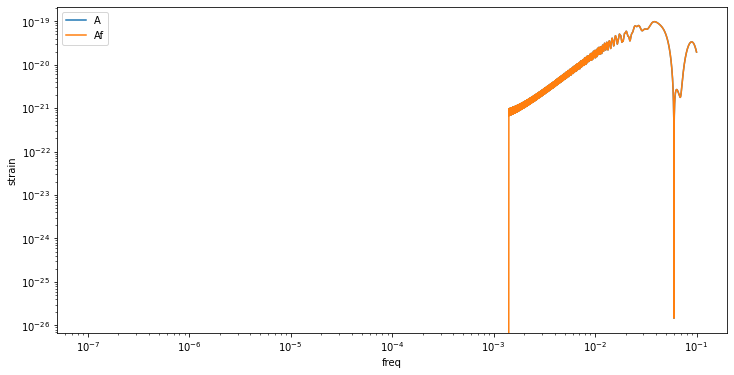

Text(0.5, 0, 'freq')

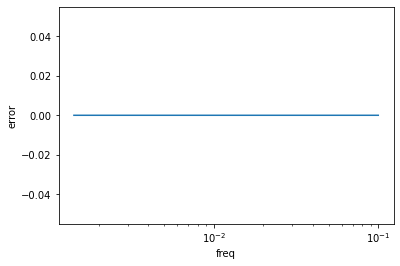

In [41]:
Nf = int (fnyquist_SMBH/df +1)
fre = df*np.arange(Nf)
i_b = int(np.rint(freqs_SMBH[0]/df))
print(Nf,f0,fre[i_b])
Af = np.zeros(Nf, dtype='complex128')
Ef = np.zeros(Nf, dtype='complex128')
Tf = np.zeros(Nf, dtype='complex128')
Af[i_b:len(TDIA_int)+ i_b] = TDIA_int
Ef[i_b:len(TDIA_int)+i_b] = TDIE_int
Tf[i_b:len(TDIA_int)+i_b] = TDIT_int
f, ax = plt.subplots(1, 1, figsize=[12,6])
plt.loglog(freqs_SMBH,np.abs(TDIA_int*freqs_SMBH),label='A',linestyle='-')
plt.loglog(fre,np.abs(Af*fre),label='Af',linestyle='-')
plt.xlabel('freq')
plt.ylabel('strain')
plt.legend()
#plt.xlim(1e-3,1e-2)
plt.show()

plt.semilogx(freqs_SMBH,np.abs(Af[i_b:len(TDIA_int)+ i_b]-TDIA_int)*freqs_SMBH)
plt.ylabel('error')
plt.xlabel('freq')

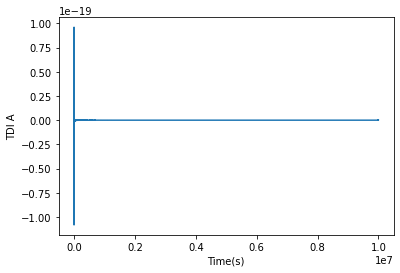

2000000


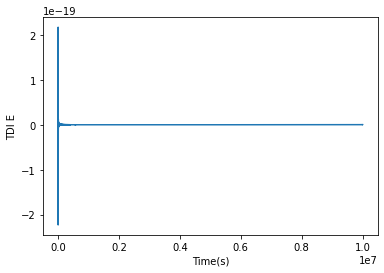

2000000


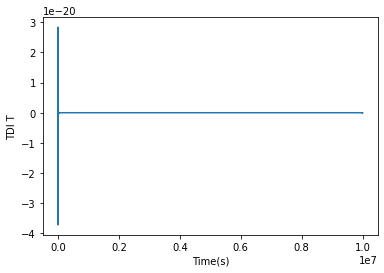

2000000


In [42]:
tm, At, Et, Tt = ComputeTD(Af, Ef, Tf, dt_SMBH)
plt.plot(tm, At)
plt.xlabel('Time(s)')
plt.ylabel('TDI A')
plt.show()
print(len(At))

plt.plot(tm, Et)
plt.xlabel('Time(s)')
plt.ylabel('TDI E')
plt.show()
print(len(Et))

plt.plot(tm, Tt)
plt.xlabel('Time(s)')
plt.ylabel('TDI T')
plt.show()
print(len(Tt))



The low-frequency limit

200000.00000000006 200000.00000000006
chirp mass 49289.164742357876
mass ratio 10.0
220000.00000000006
m10,m20 20.000000000000007 2.000000000000001
flow 2.272727272727272
rescale 10000.0
Fs 0.002


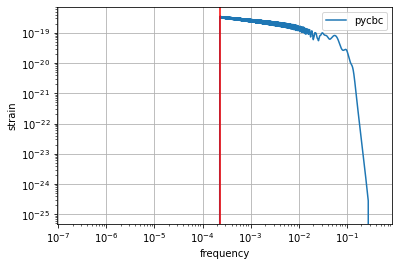

In [44]:
%matplotlib inline
m10=m1=mass1_from_mchirp_q(chirp_mass,q)
m20=m2=mass2_from_mchirp_q(chirp_mass,q)

print(m10,m1)
print('chirp mass',chirp_mass)
print('mass ratio',q)

M1=m1+ m2 
print(M1)
#m1 >m2


while(m10>100):
    m10=m10/10
if(m10>50):
    m10=m10/4
m20=m10/q
print('m10,m20',m10,m20)

M0=m10+m20
flower=50/M0
print('flow',flower)
apx = ['SEOBNRv4HM','IMRPhenomXHM','IMRPhenomD']
rescale=M1/M0
print('rescale',rescale)


modes=[[[2,2]],[[2,2],[2,1],[3,2],[3,3],[4,4]],[[2,2],[2,1],[3,2],[3,3],[4,4]]] 
Fs=(2e-07)*rescale
print('Fs',Fs)



hpf, hcf = get_fd_waveform(approximant=apx[1],
                         mass1=m10,
                         mass2=m20,
                         spin1z=chi1,
                         spin2z=chi2,
                         distance=DL,
                         inclination=inc,
                         coa_phase=phi0,
                         delta_f=Fs,
                         f_lower=flower,
                         mode_array=modes[1])

#rescale the time/frequency and amplitude
hpf=types.FrequencySeries(hpf.data.data[:],delta_f=hpf.delta_f/rescale)*rescale**2
hcf=types.FrequencySeries(hcf.data.data[:],delta_f=hcf.delta_f/rescale)*rescale**2


plt.loglog(hpf.sample_frequencies,abs(hpf)*hpf.sample_frequencies,label='pycbc')
plt.axvline(x=flower/rescale,color='red')
plt.xlabel('frequency')
plt.ylabel('strain')
#plt.xlim(1e-5,1)
plt.legend()
plt.grid()
plt.show()


In [46]:
#response function
def FLISA(t,lambd,beta,psi,t0):
    alpha= 2*np.pi*(t-t0)      #t,t0: yr
    #print(alpha)
    beta_L= np.arcsin(np.cos(np.pi/3)*np.sin(beta)-np.sin(np.pi/3)*np.cos(beta)*np.cos(lambd-alpha))
    lambd_L= arctan(np.cos(beta)*np.cos(lambd)*(np.cos(np.pi/3)*np.cos(alpha)**2+np.sin(alpha)**2)+\
                    np.cos(beta)*np.sin(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+\
                    np.sin(np.pi/3)*np.sin(beta)*np.cos(alpha)+\
                    np.cos(beta)*np.sin(lambd)*(np.cos(np.pi/3)*np.sin(alpha)**2+np.cos(alpha)**2)+\
                    np.cos(beta)*np.cos(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+
                    np.sin(np.pi/3)*np.sin(beta)*np.sin(alpha))
    psi_L= psi +np.arctan(np.cos(pi/3)*np.cos(beta)+np.sin(np.pi/3)*np.sin(beta)*np.cos(lambd-alpha)-np.sin(np.pi/3)*np.sin(lambd-alpha))

    F_a_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L-np.pi/3)/2
    F_a_cross = np.sin(beta_L)*np.sin(2*lambd_L-np.pi/3)
    F_e_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L+np.pi/6)/2
    F_e_cross = np.sin(beta_L)*np.sin(2*lambd_L+np.pi/6)
    #include the polarization angle in the pattern function
    Fa_plus = np.cos(2*psi_L)*F_a_plus + np.sin(2*psi_L) *F_a_cross
    Fe_plus = np.cos(2*psi_L)*F_e_plus + np.sin(2*psi_L) *F_e_cross
    Fa_cross = -np.sin(2*psi_L)*F_a_plus + np.cos(2*psi_L) *F_a_cross
    Fe_cross = -np.sin(2*psi_L)*F_e_plus + np.cos(2*psi_L) *F_e_cross
    return Fa_plus,Fa_cross,Fe_plus,Fe_cross





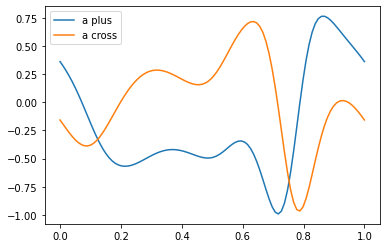

In [47]:
tmp_time= np.linspace(0,1,100)
Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(tmp_time,lambd,beta,psi,t0=0)
plt.plot(tmp_time,Fa_plus,label='a plus')
plt.plot(tmp_time,Fa_cross,label='a cross')
plt.legend()


In [89]:
# def F(t,theta,phi,psi):
#     alpha=2*np.pi*1*t
#     beta=2*np.pi/3           #the relative phase of three spacecrafts 
#     D_plus=np.sqrt(3)/64*(-36*np.sin(theta)**2*np.sin(2*alpha-2*beta)+
#                          (3+np.cos(2*theta))*(np.cos(2*phi)*(9*np.sin(2*beta)-np.sin(4*alpha-2*beta)))+
#                          np.sin(2*phi)*(np.cos(4*alpha-2*beta)-9*np.cos(2*beta))-
#                          4*np.sqrt(3)*np.sin(2*theta)*(np.sin(3*alpha-2*beta-phi)-
#                                                       3*np.sin(alpha-2*beta+phi)))
#     D_mul=(np.sqrt(3)*np.cos(theta)*(9*np.cos(2*phi-2*beta)-np.cos(4*alpha-2*beta-2*phi))-
#            6*np.sin(theta)*(np.cos(3*alpha-2*beta-phi)+3*np.cos(alpha-2*beta+phi)))/16.0    
    
#     F_plus= ((np.cos(2*psi)*D_plus-np.sin(2*psi)*D_mul))/2
#     F_cross= ((np.sin(2*psi)*D_plus+np.cos(2*psi)*D_mul))/2
#     return F_plus,F_cross

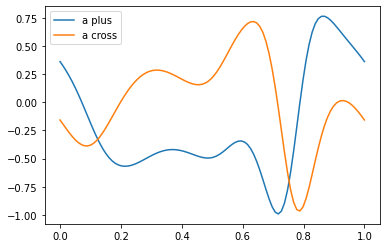

In [48]:
tmp_time= np.linspace(0,1,100)
Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(tmp_time,lambd,beta,psi,t0=0)
# F_plus,F_cross = F(tmp_time,theta,phi,psi)
plt.plot(tmp_time,Fa_plus,label='a plus')
plt.plot(tmp_time,Fa_cross,label='a cross')
plt.legend()
plt.show()
# plt.plot(tmp_time,F_plus,label='plus')
# plt.plot(tmp_time,F_cross,label='cross')
# plt.legend()

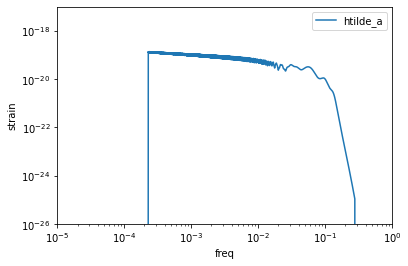

In [50]:
# hf= F_plus[0]*hpf + F_cross[0]*hcf
htilde_a = Fa_plus[0]*hpf + Fa_cross[0]*hcf

# plt.loglog(hf.sample_frequencies,abs(hf)*hf.sample_frequencies,label='F+h+ +Fxhx')
plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_a.sample_frequencies,label='htilde_a')
plt.legend()
plt.xlim(1e-5,1e-0)
plt.ylim(1e-26,1e-17)
plt.xlabel('freq')
plt.ylabel('strain')
plt.show()

# plt.loglog(hf.sample_frequencies,np.abs(htilde_a-hf)*hf.sample_frequencies)
# plt.xlim(1e-5,1e-1)
# plt.ylim(1e-26,1e-18)
# plt.xlabel('freq')
# plt.ylabel('(htilde_a-hf)*f')
# plt.show()

# plt.plot(hf.sample_frequencies,(np.abs(htilde_a)-np.abs(hf))*hf.sample_frequencies)
# #plt.xlim(1e-5,1e-1)
# #plt.ylim(1e-26,1e-18)
# plt.xlabel('freq')
# plt.ylabel('(|htilde_a|-|hf|)*f')
# plt.show()
